# Finetune Embeddings

In this notebook, we finetune the `bge-large-en-v1.5` model. A lot of code and text excerpts here were taken from the [official documentation](https://github.com/FlagOpen/FlagEmbedding/tree/master/examples/finetune)

In [1]:
!pip install /kaggle/input/mathllm-packages/sentence_transformers-3.2.1-py3-none-any.whl -q
!pip install /kaggle/input/mathllm-packages/peft-0.13.2-py3-none-any.whl -q
!pip install /kaggle/input/mathllm-packages/FlagEmbedding-1.2.11-py3-none-any.whl -q
!pip install faiss-gpu -q
# !pip install git+https://github.com/FlagOpen/FlagEmbedding.git faiss-gpu -q

In [2]:
import os, re, json
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from transformers import AutoTokenizer

tqdm.pandas()
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [3]:
# model_id = 'BAAI/bge-large-en-v1.5'
model_id = '/kaggle/input/mathllm-model/eedi_model'

comp_dir = '/kaggle/input/eedi-mining-misconceptions-in-mathematics'

In [24]:
train          = pd.read_csv(f'{comp_dir}/train.csv')
misconceptions = pd.read_csv(f'{comp_dir}/misconception_mapping.csv')

train["AllQuestionText"] = train["SubjectName"] + " ### " + train["ConstructName"] + " ### " + train["QuestionText"]

keep_cols           = ["QuestionId", "AllQuestionText", "CorrectAnswer"]
answer_cols         = ["AnswerAText", "AnswerBText", "AnswerCText", "AnswerDText"]
misconception_cols  = ["MisconceptionAId", "MisconceptionBId", "MisconceptionCId", "MisconceptionDId"]

def wide_to_long(df: pd.DataFrame) -> pd.DataFrame:
    # Melt the answer columns
    answers_df = pd.melt(
        id_vars=keep_cols,
        frame=df[keep_cols + answer_cols],
        var_name='Answer', value_name='Value'
    ).sort_values(["QuestionId", "Answer"]).reset_index(drop=True)
    
    # If NOT test set
    if misconception_cols[0] in df.columns:
        
        # Melt the misconception columns
        misconceptions_df = pd.melt(
            id_vars=keep_cols,
            frame=df[keep_cols + misconception_cols],
            var_name='Misconception', value_name='MisconceptionId'
        ).sort_values(["QuestionId", "Misconception"]).reset_index(drop=True)

        answers_df[['Misconception', 'MisconceptionId']] = misconceptions_df[['Misconception', 'MisconceptionId']]
    
    return answers_df

train = wide_to_long(train)

# https://www.kaggle.com/code/pshikk/similarity-preprocessing

def preprocess_text(x):
    x = x.lower()                 # Convert words to lowercase
    x = re.sub("@\w+", '',x)      # Delete strings starting with @
    x = re.sub("'\d+", '',x)      # Delete Numbers
    x = re.sub("\d+", '',x)
    x = re.sub("http\w+", '',x)   # Delete URL
    x = re.sub(r"\s+", " ", x)    # Replace consecutive empty spaces with a single space character
    x = re.sub(r"\.+", ".", x)    # Replace consecutive commas and periods with one comma and period character
    x = re.sub(r"\,+", ",", x)
    x = x.strip()                 # Remove empty characters at the beginning and end
    return x

train["AllText"] = train["AllQuestionText"] + " ### " + train["Value"]
train['AnswerId'] = train.Answer.str.replace('Answer', '').str.replace('Text', '')
train.drop(['AllQuestionText', 'Answer', 'Misconception'], axis=1, inplace=True)

# train = train[train.AnswerId != train.CorrectAnswer].reset_index(drop=True)

train.loc[train['AnswerId'] == train['CorrectAnswer'], 'MisconceptionId'] = 2587
correct = [2587, "Correct Answer."]
correct_pd = pd.DataFrame(columns=misconceptions.columns, data=[correct])
misconceptions = pd.concat([misconceptions, correct_pd], ignore_index = True)

train = pd.merge(train, misconceptions, on='MisconceptionId', how='left')

train = train.dropna()

train["AllText"] = train["AllText"].apply(preprocess_text)
train["MisconceptionName"] = train["MisconceptionName"].apply(preprocess_text)

print(len(train), len(misconceptions))
train

6239 2588


,QuestionId,CorrectAnswer,Value,MisconceptionId,AllText,AnswerId,MisconceptionName
0,0,A,\( 3 \times(2+4)-5 \),2587.0,bidmas ### use the order of operations to carr...,A,correct answer.
3,0,A,Does not need brackets,1672.0,bidmas ### use the order of operations to carr...,D,"confuses the order of operations, believes add..."
4,1,D,\( m+1 \),2142.0,simplifying algebraic fractions ### simplify a...,A,does not know that to factorise a quadratic ex...
5,1,D,\( m+2 \),143.0,simplifying algebraic fractions ### simplify a...,B,thinks that when you cancel identical terms fr...
6,1,D,\( m-1 \),2142.0,simplifying algebraic fractions ### simplify a...,C,does not know that to factorise a quadratic ex...
...,...,...,...,...,...,...,...
7471,1867,B,Neither is correct,2312.0,congruency in other shapes ### distinguish bet...,D,thinks congruent shapes are the same shape but...
7472,1868,B,Only\nJo,801.0,rotation ### describe a ° or ° rotation giving...,A,forgets to give the centre of rotation
7473,1868,B,Only Paul,2587.0,rotation ### describe a ° or ° rotation giving...,B,correct answer.
7474,1868,B,Both Jo and Paul,801.0,rotation ### describe a ° or ° rotation giving...,C,forgets to give the centre of rotation


### Infer optimal max_lengths for query and context

Looking at the grphs, 256 for query and 64 for misconceptions seem like a good limit

  0%|          | 0/6239 [00:00<?, ?it/s]

  0%|          | 0/2588 [00:00<?, ?it/s]

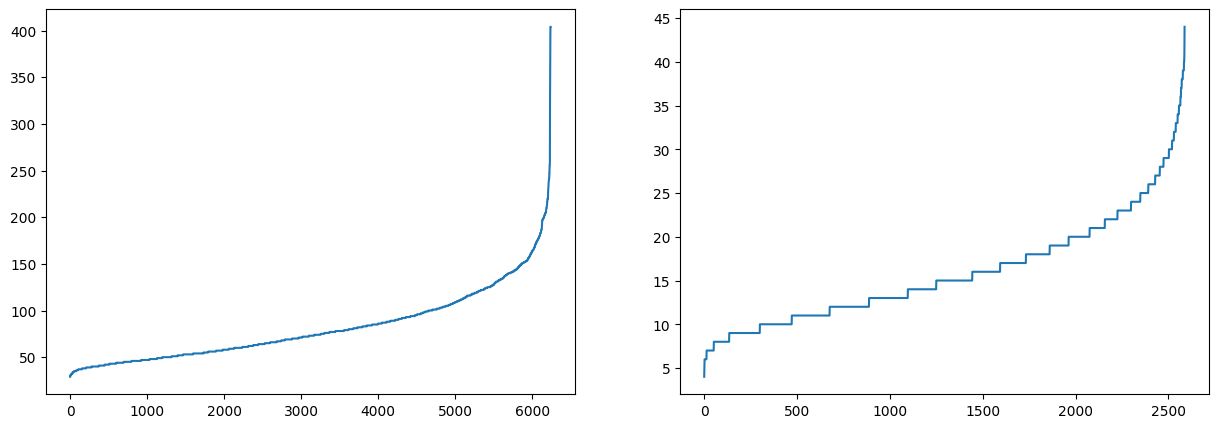

In [25]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

all_texts_len = train['AllText'].progress_apply(lambda x: len(tokenizer(x)['input_ids']))
misconceptions_len = misconceptions['MisconceptionName'].progress_apply(lambda x: len(tokenizer(x)['input_ids']))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

_ = all_texts_len.sort_values().reset_index(drop=True).plot.line(ax=ax1)
_ = misconceptions_len.sort_values().reset_index(drop=True).plot.line(ax=ax2)

## Data format
Train data should be a json file, where each line is a dict like this:

```
{"query": str, "pos": List[str], "neg":List[str]}
```

`query` is the query, and `pos` is a list of positive texts, `neg` is a list of negative texts.
If you have no negative texts for a query, you can random sample some from the entire corpus as the negatives.

See [toy_finetune_data.jsonl](https://github.com/FlagOpen/FlagEmbedding/blob/master/examples/finetune/toy_finetune_data.jsonl) for a toy data file.

In [26]:
pretrain_data = [{'text': preprocess_text(misconception)} for misconception in list(misconceptions.MisconceptionName.values)]

finetune_data = [
    {
        'query': query.strip(),
        'pos': [misconception.strip()],
        'neg': []    # Leave empty, to be populated by hard mining algorithm below
    } for query, misconception in train[['AllText', 'MisconceptionName']].values
]

len(pretrain_data), len(finetune_data)

(2588, 6239)

In [27]:
finetune_data[0]

{'query': 'bidmas ### use the order of operations to carry out calculations involving powers ### \\[ \\times +- \\] where do the brackets need to go to make the answer equal \\( \\) ? ### \\( \\times(+)- \\)',
 'pos': ['correct answer.'],
 'neg': []}

In [28]:
with open('pretrain_data.jsonl', 'w') as f:
    for entry in pretrain_data:
        json.dump(entry, f)
        f.write('\n')
        
with open('finetune_data.jsonl', 'w') as f:
    for entry in finetune_data:
        json.dump(entry, f)
        f.write('\n')

## Hard Negatives
Hard negatives is a widely used method to improve the quality of sentence embedding. You can mine hard negatives following this command:

- `input_file`: json data for finetuning. This script will retrieve top-k documents for each query, 
and random sample negatives from the top-k documents (not including the positive documents).
- `output_file`: path to save JSON data with mined hard negatives for finetuning
- `negative_number`: the number of sampled negatives 
- `range_for_sampling`: where to sample negative. For example, `2-100` means sampling `negative_number` negatives from top2-top200 documents. **You can set larger value to reduce the difficulty of negatives (e.g., set it `60-300` to sample negatives from top60-300 passages)**
- `candidate_pool`: The pool to retrieval. The default value is None, and this script will retrieve from the combination of all `neg` in `input_file`. 
The format of this file is the same as [pretrain data](https://github.com/FlagOpen/FlagEmbedding/tree/master/examples/pretrain#2-data-format). If input a candidate_pool, this script will retrieve negatives from this file.
- `use_gpu_for_searching`: whether to use faiss-gpu to retrieve negatives.


In [29]:
!python -m FlagEmbedding.baai_general_embedding.finetune.hn_mine \
    --model_name_or_path {model_id} \
    --input_file finetune_data.jsonl \
    --candidate_pool pretrain_data.jsonl \
    --output_file finetune_data_minedHN.jsonl \
    --range_for_sampling 2-300 \
    --negative_number 50 \
    --use_gpu_for_searching


finetune_data_minedHN = []
with open('finetune_data_minedHN.jsonl', 'r') as file:
    for line in file:
        finetune_data_minedHN.append(json.loads(line))

----------using 2*GPUs----------
inferencing embedding for corpus (number=2551)--------------
Inference Embeddings:   0%|                               | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Inference Embeddings: 100%|███████████████████████| 5/5 [00:03<00:00,  1.34it/s]
inferencing embedding for queries (number=6239)--------------
Inference Embeddings: 100%|█████████████████████| 13/13 [00:28<00:00,  2.18s/it]
create index and search------------------
Batches: 100%|█████████████████████████████████| 98/98 [00:00<00:00, 323.34it/s]


In [30]:
finetune_data_minedHN[0]    # negs are now populated

{'query': 'bidmas ### use the order of operations to carry out calculations involving powers ### \\[ \\times +- \\] where do the brackets need to go to make the answer equal \\( \\) ? ### \\( \\times(+)- \\)',
 'pos': ['correct answer.'],
 'neg': ['believes squaring a negative number just changes the sign',
  'adds instead of multiplying when expanding bracket',
  'believes multiplying two negatives gives a negative answer',
  'done a different calculation to the one given',
  'when adding/subtracting fractions, adds/subtracts the denominators and multiplies the numerators',
  'thinks that when dividing numbers in standard form you subtract the number and divide the power',
  'converted hours to minutes instead of hours to seconds',
  'multiplied the base numbers',
  'carries out operations from right to left regardless of priority order',
  'does not realise that division can be used to find the missing value in a multiplication problem',
  'multiplies by the index',
  'does not under

## Train

**some important arguments**:
- `per_device_train_batch_size`: batch size in training. In most of cases, larger batch size will bring stronger performance. You can expand it by enabling `--fp16`, `--deepspeed ./df_config.json` (df_config.json can refer to [ds_config.json](./ds_config.json)), `--gradient_checkpointing`, etc. 
- `train_group_size`: the number of positive and negatives for a query in training.
There are always one positive, so this argument will control the number of negatives (#negatives=train_group_size-1).
Noted that the number of negatives should not be larger than the numbers of negatives in data `"neg":List[str]`.
Besides the negatives in this group, the in-batch negatives also will be used in fine-tuning.
- `negatives_cross_device`: share the negatives across all GPUs. This argument will extend the number of negatives.
- `learning_rate`: select a appropriate for your model. Recommend 1e-5/2e-5/3e-5 for large/base/small-scale. 
- `temperature`: It will influence the distribution of similarity scores. **Recommended value: 0.01-0.1.**
- `query_max_len`: max length for query. Please set it according the average length of queries in your data.
- `passage_max_len`: max length for passage. Please set it according the average length of passages in your data.
- `query_instruction_for_retrieval`: instruction for query, which will be added to each query. You also can set it `""` to add nothing to query.
- `use_inbatch_neg`: use passages in the same batch as negatives. Default value is True. 
- `save_steps`: for setting how many training steps to save a checkpoint.

For more training arguments please refer to [transformers.TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments)

In [31]:
!torchrun --nproc_per_node 2 -m FlagEmbedding.baai_general_embedding.finetune.run \
    --output_dir eedi_model \
    --model_name_or_path {model_id} \
    --train_data finetune_data_minedHN.jsonl \
    --learning_rate 1e-5 \
    --fp16 \
    --temperature 0.03 \
    --num_train_epochs 3 \
    --per_device_train_batch_size 8 \
    --query_max_len 256 \
    --passage_max_len 64 \
    --logging_steps 100 \
    --query_instruction_for_retrieval "" \
    --report_to none \
    --save_strategy "no"
    --save_steps 0

IndentationError: unexpected indent (1550146222.py, line 2)